In [35]:
!pip install bertopic scikit-learn pyLDAvis==3.3.1 matplotlib pandas datasets

  Using cached pyLDAvis-3.3.1.tar.gz (1.7 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


DEPRECATION: Loading egg at c:\users\arpan\anaconda3\envs\text_analytics\lib\site-packages\huggingface_hub-0.29.1-py3.8.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
      

In [36]:
import re
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# Download NLTK resources (run once)
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arpan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arpan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arpan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Training dataset with 800 instances loaded
Development/validation dataset with 200 instances loaded
=== LDA Analysis ===

=== Results ===

LDA Basic (5 topics, unigrams):


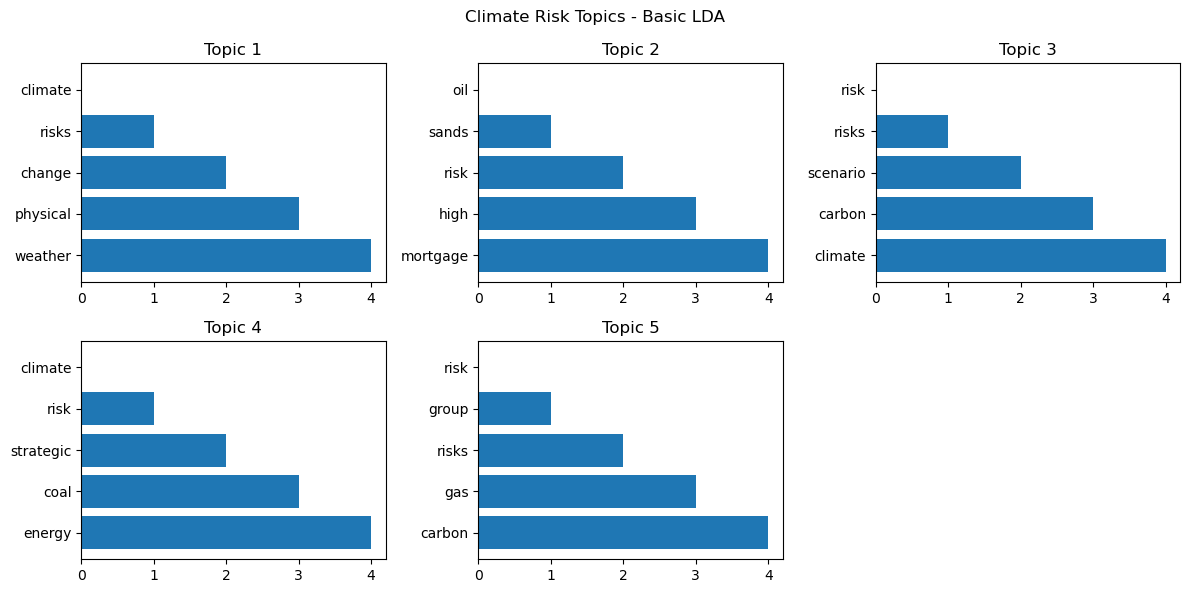

Topic 1: ['climate', 'risks', 'change', 'physical', 'weather']
Topic 2: ['oil', 'sands', 'risk', 'high', 'mortgage']
Topic 3: ['risk', 'risks', 'scenario', 'carbon', 'climate']
Topic 4: ['climate', 'risk', 'strategic', 'coal', 'energy']
Topic 5: ['risk', 'group', 'risks', 'gas', 'carbon']

LDA Enhanced (8 topics, bigrams):


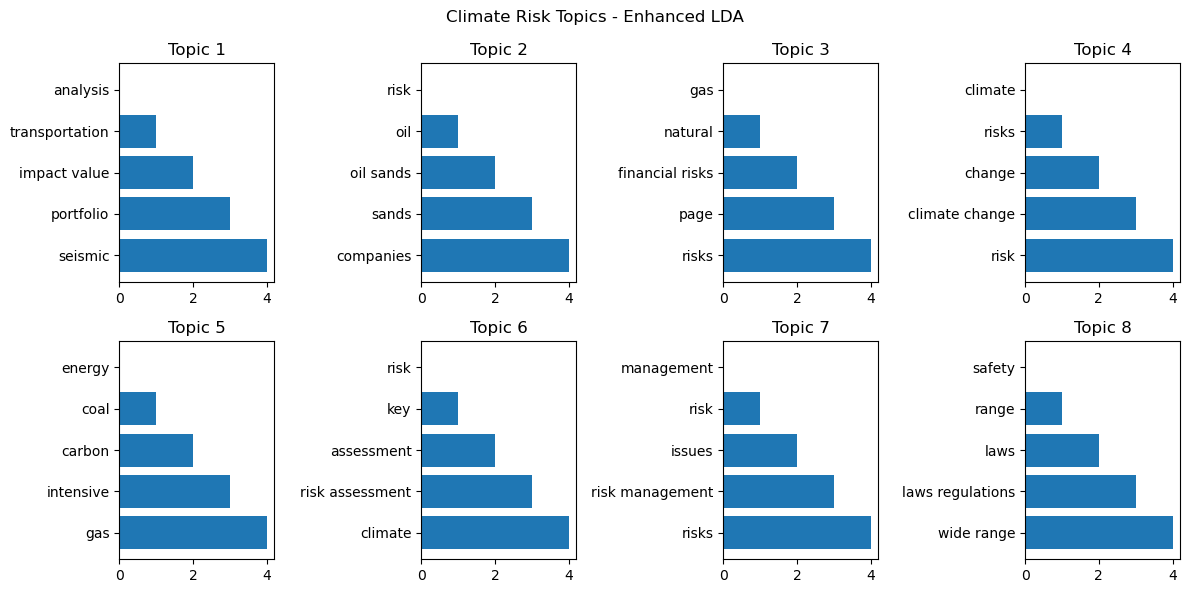

Topic 1: ['analysis', 'transportation', 'impact value', 'portfolio', 'seismic']
Topic 2: ['risk', 'oil', 'oil sands', 'sands', 'companies']
Topic 3: ['gas', 'natural', 'financial risks', 'page', 'risks']
Topic 4: ['climate', 'risks', 'change', 'climate change', 'risk']
Topic 5: ['energy', 'coal', 'carbon', 'intensive', 'gas']
Topic 6: ['risk', 'key', 'assessment', 'risk assessment', 'climate']
Topic 7: ['management', 'risk', 'issues', 'risk management', 'risks']
Topic 8: ['safety', 'range', 'laws', 'laws regulations', 'wide range']

=== Results ===

LDA Basic (5 topics, unigrams):


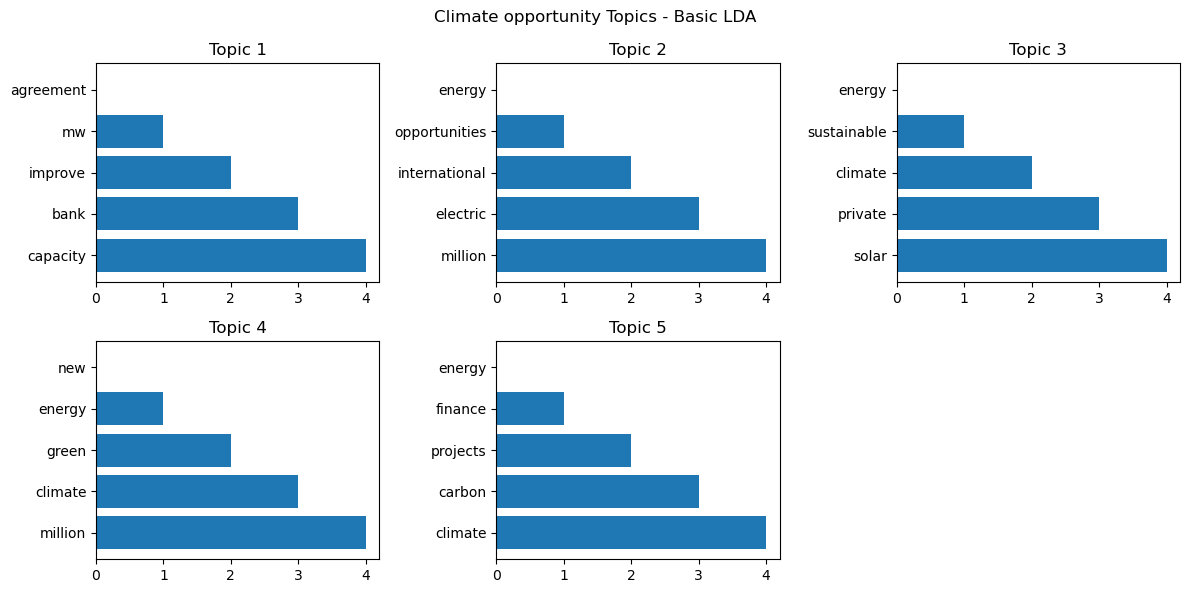

Topic 1: ['agreement', 'mw', 'improve', 'bank', 'capacity']
Topic 2: ['energy', 'opportunities', 'international', 'electric', 'million']
Topic 3: ['energy', 'sustainable', 'climate', 'private', 'solar']
Topic 4: ['new', 'energy', 'green', 'climate', 'million']
Topic 5: ['energy', 'finance', 'projects', 'carbon', 'climate']

LDA Enhanced (8 topics, bigrams):


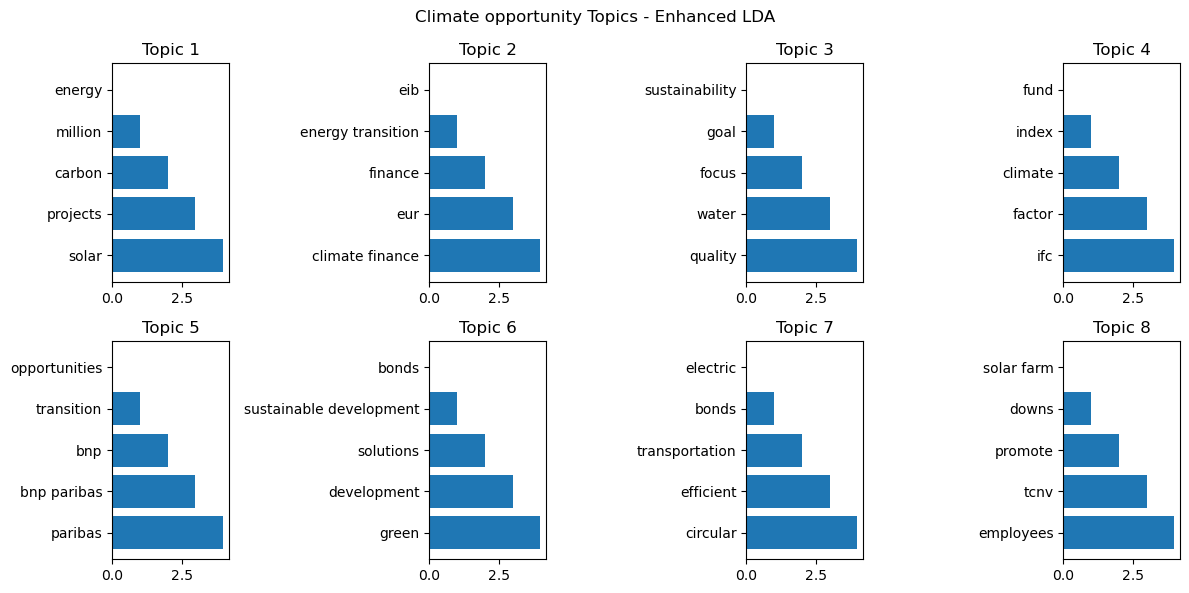

Topic 1: ['energy', 'million', 'carbon', 'projects', 'solar']
Topic 2: ['eib', 'energy transition', 'finance', 'eur', 'climate finance']
Topic 3: ['sustainability', 'goal', 'focus', 'water', 'quality']
Topic 4: ['fund', 'index', 'climate', 'factor', 'ifc']
Topic 5: ['opportunities', 'transition', 'bnp', 'bnp paribas', 'paribas']
Topic 6: ['bonds', 'sustainable development', 'solutions', 'development', 'green']
Topic 7: ['electric', 'bonds', 'transportation', 'efficient', 'circular']
Topic 8: ['solar farm', 'downs', 'promote', 'tcnv', 'employees']


In [37]:
train_dataset = load_dataset(
    "climatebert/climate_sentiment",
    split="train",
)

# we're going to create a new validation set by splitting the data
dataset_splits = train_dataset.train_test_split(test_size=0.2)
train_dataset = dataset_splits["train"]
val_dataset = dataset_splits["test"]

train_texts = np.array(train_dataset["text"])
val_texts = np.array(val_dataset["text"])

train_labels = np.array(train_dataset["label"])
val_labels = np.array(val_dataset["label"])

print(f"Training dataset with {len(train_texts)} instances loaded")
print(f"Development/validation dataset with {len(val_texts)} instances loaded")


df = train_dataset.to_pandas()
risk_texts = df[df['label'] == 0]['text'].tolist()
opportunity_texts = df[df['label'] == 2]['text'].tolist()

# Method 1: LDA with TF-IDF (Two Variations)
def run_lda_analysis(texts, n_components, max_features=1000, use_bigrams=False):
    """Run LDA analysis with configurable parameters"""
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        stop_words='english',
        ngram_range=(1,2) if use_bigrams else (1,1))
    
    dtm = vectorizer.fit_transform(texts)
    lda = LatentDirichletAllocation(n_components=n_components, random_state=42)
    lda.fit(dtm)
    
    return {
        'model': lda,
        'vectorizer': vectorizer,
        'topics': [
            [word for word, _ in sorted(zip(vectorizer.get_feature_names_out(), topic), 
             key=lambda x: x[1], reverse=True)[:10]]
            for topic in lda.components_]
    }

# Compare LDA variations
print("=== LDA Analysis ===")
lda_risk_basic = run_lda_analysis(risk_texts, n_components=5, use_bigrams=False)
lda_risk_enhanced = run_lda_analysis(risk_texts, n_components=8, use_bigrams=True)

lda_opportunity_texts_basic = run_lda_analysis(opportunity_texts, n_components=5, use_bigrams=False)
lda_opportunity_texts_enhanced = run_lda_analysis(opportunity_texts, n_components=8, use_bigrams=True)

# Visualization functions
def visualize_topics(topics, title):
    """Visualize topics with matplotlib"""
    plt.figure(figsize=(12, 6))
    for i, topic in enumerate(topics):
        plt.subplot(2, (len(topics)+1)//2, i+1)
        plt.barh(topic[:5], range(5))
        plt.title(f'Topic {i+1}')
        plt.gca().invert_yaxis()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Results and Interpretation
print("\n=== Results ===")
print("\nLDA Basic (5 topics, unigrams):")
visualize_topics(lda_risk_basic['topics'], "Climate Risk Topics - Basic LDA")
for i, topic in enumerate(lda_risk_basic['topics']):
    print(f"Topic {i+1}: {topic[:5]}")

print("\nLDA Enhanced (8 topics, bigrams):")
visualize_topics(lda_risk_enhanced['topics'], "Climate Risk Topics - Enhanced LDA")
for i, topic in enumerate(lda_risk_enhanced['topics']):
    print(f"Topic {i+1}: {topic[:5]}")
#---------------------------------------------
print("\n=== Results ===")
print("\nLDA Basic (5 topics, unigrams):")
visualize_topics(lda_opportunity_texts_basic['topics'], "Climate opportunity Topics - Basic LDA")
for i, topic in enumerate(lda_opportunity_texts_basic['topics']):
    print(f"Topic {i+1}: {topic[:5]}")

print("\nLDA Enhanced (8 topics, bigrams):")
visualize_topics(lda_opportunity_texts_enhanced['topics'], "Climate opportunity Topics - Enhanced LDA")
for i, topic in enumerate(lda_opportunity_texts_enhanced['topics']):
    print(f"Topic {i+1}: {topic[:5]}")